In [1]:
import spacy
from collections import Counter
import tomotopy as tp
import os
from tqdm import tqdm
import pandas

## Prepare data

In [2]:
# Load german model
nlp = spacy.load('de_core_news_lg')

In [3]:
custom_stopwords = ['B.', '$', 'Fig', 'z.', 'MATH', '=']

In [4]:
for c in custom_stopwords:
    nlp.vocab[c].is_stop = True

In [5]:
# Parse files
file_list = []
for file in os.listdir('data/all_txt/'):
    file_list.append(file)

In [6]:
# Create a dictionary of all lemmatized texts
texts = dict()
for file in tqdm(file_list):
    with open(f'data/all_txt/{file}', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('¬\n', '')
        doc = nlp(text)
        name = file.split('.')[0]
        
        texts[name] = doc
        

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:00<00:00, 22.59s/it]


## Basic statistics

In [7]:
entries = []
for name, txt in texts.items():
    words = [token.text
         for token in txt
         if not token.is_stop and not token.is_punct and not token.is_space]
    nouns = [token.text
         for token in txt
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == "NOUN")]
    vocab = set(words)
    
    # most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(10)

    # most common noun tokens
    noun_freq = Counter(nouns)
    common_nouns = noun_freq.most_common(10)

    # vocabulary size
    vocab_size = len(vocab)
    
    entry = {
        'name': name,
        'common words': common_words,
        'common nouns': common_nouns,
        'vocabulary size': vocab_size,
    }
    
    entries.append(entry)
    

In [8]:
glob_words = []
glob_nouns = []

for name, txt in texts.items():
    for token in txt:
        if not token.is_stop and not token.is_punct and not token.is_space:
            glob_words.append(token.text)
        if (not token.is_stop and not token.is_punct and token.pos_ == "NOUN"):
            glob_nouns.append(token.text)

glob_vocab = set(glob_words)

# most common tokens
word_freq = Counter(glob_words)
glob_common_words = word_freq.most_common(10)

# most common noun tokens
noun_freq = Counter(glob_nouns)
glob_common_nouns = noun_freq.most_common(10)

# vocabulary size
glob_vocab_size = len(glob_vocab)

glob_entry = {
    'name': 'all texts',
    'common words': glob_common_words,
    'common nouns': glob_common_nouns,
    'vocabulary size': glob_vocab_size,
}

entries.append(glob_entry)


In [9]:
glob_entry

{'name': 'all texts',
 'common words': [('Töne', 662),
  ('c', 605),
  ('e', 543),
  ('Terz', 476),
  ('g', 450),
  ('Ton', 436),
  ('C', 435),
  ('Folge', 407),
  ('Bedeutung', 406),
  ('h', 400)],
 'common nouns': [('Töne', 662),
  ('Terz', 439),
  ('Ton', 435),
  ('Folge', 407),
  ('Bedeutung', 406),
  ('Tonart', 352),
  ('Grundton', 348),
  ('Accorde', 282),
  ('Dissonanz', 254),
  ('Dreiklang', 240)],
 'vocabulary size': 19570}

In [10]:
df = pandas.DataFrame(data=entries)
df

,name,common words,common nouns,vocabulary size
0,CAP1905,"[(c, 161), (S., 159), (e, 159), (g, 128), (C, ...","[(S., 154), (Terz, 52), (Grundton, 51), (Töne,...",4915
1,HAU1853,"[(Quint, 305), (Terz, 254), (Folge, 249), (Bed...","[(Folge, 249), (Bedeutung, 235), (Terz, 233), ...",7905
2,KUN1863,"[(2c, 85), (Verfasser, 83), (Töne, 76), (Seite...","[(2c, 85), (Verfasser, 83), (Töne, 76), (Seite...",5315
3,NAU1858,"[(Töne, 110), (Terz, 63), (gr, 58), (C, 58), (...","[(Töne, 110), (Terz, 63), (Quinte, 46), (Octav...",2751
4,OET1866,"[(c, 341), (1, 255), (g, 255), (e, 230), (d, 2...","[(Töne, 189), (Ton, 145), (Klänge, 144), (Verw...",6781
5,RIE1905,"[(Töne, 38), (Konsonanz, 30), (Ton, 28), (Terz...","[(Töne, 38), (Konsonanz, 30), (Ton, 28), (Terz...",2329
6,WEI1860,"[(C, 55), (Tonart, 47), (Töne, 46), (folgenden...","[(Tonart, 47), (Töne, 46), (Quinte, 34), (Acco...",1860
7,WEI1861,"[(Tonart, 30), (Herr, 25), (Schrift, 22), (S.,...","[(Tonart, 30), (Herr, 25), (Schrift, 22), (Kri...",1727
8,all texts,"[(Töne, 662), (c, 605), (e, 543), (Terz, 476),...","[(Töne, 662), (Terz, 439), (Ton, 435), (Folge,...",19570


In [11]:
df.to_csv('text_stats.csv', encoding='utf-8')

## Topic modelling

In [12]:
mdl = tp.LDAModel(k=5)

In [13]:
for txt in texts.values():
    words = [token.text
         for token in txt
         if not token.is_stop and not token.is_punct and not token.is_space]
    for i in range(0,len(words),100):
        mdl.add_doc(words[i: i+100])

In [14]:
mdl.train(500)

In [15]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

Top 10 words of topic #0
[('Bestimmung', 0.012164127081632614), ('Einheit', 0.011526988819241524), ('Bedeutung', 0.010194790549576283), ('Metrum', 0.007588316220790148), ('Ordnung', 0.007530394475907087), ('Quint', 0.007356629706919193), ('metrischen', 0.006893256679177284), ('Glied', 0.006777413189411163), ('enthalten', 0.005966510158032179), ('metrische', 0.005850666668266058)]
Top 10 words of topic #1
[('Töne', 0.008368676528334618), ('Musik', 0.0073416586965322495), ('Theorie', 0.004983320366591215), ('Intervalle', 0.004679019097238779), ('musikalischen', 0.004450792912393808), ('musikalische', 0.0037280761171132326), ('reinen', 0.0036520007997751236), ('Octave', 0.003499849932268262), ('2c', 0.0033476990647614002), ('Quinten', 0.0031194728799164295)]
Top 10 words of topic #2
[('C', 0.015416481532156467), ('Töne', 0.015191101469099522), ('Terz', 0.014695263467729092), ('Grundton', 0.014514959417283535), ('Dissonanz', 0.011539936065673828), ('Ton', 0.011269479058682919), ('Quint', 0

In [16]:
import pyLDAvis
import numpy as np 

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists,
    doc_topic_dists,
    doc_lengths,
    vocab,
    term_frequency,
    sort_topics=False,
    start_index=0,
)



In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
# pca = PCA(n_components=2)
pca = MDS(n_components=2)
X = pca.fit_transform(topic_term_dists)

C:\Users\cmetrai2\anaconda3\envs\doc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\cmetrai2\anaconda3\envs\doc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


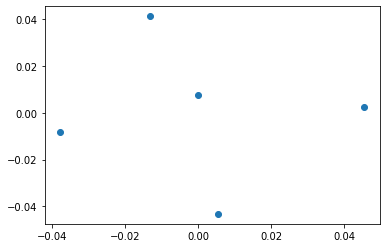

In [18]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1])

- 2 Figures
    1. PCA/MDS of document vectors (TF-IDF)
    2. PCA/MDS of topic-term dists 
    3. Table of top 10 words for topics

In [19]:
pyLDAvis.save_html(prepared_data, "ldavis.html")

C:\Users\cmetrai2\anaconda3\envs\doc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
pyLDAvis.enable_notebook()

C:\Users\cmetrai2\anaconda3\envs\doc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
pyLDAvis.display(prepared_data)

C:\Users\cmetrai2\anaconda3\envs\doc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
